<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/pt_to_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install google-auth
from google.colab import auth
from google.colab import drive

drive.mount('/content/drive')

# !pip install torchvision
!pip install onnx
# !pip install tensorflow
!pip install onnx_tf

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.0 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.onnx
from torch.autograd import Variable

# Define the PyTorch model class
class Model(nn.Module):
    def __init__(self, in_features=6, h1=61, h2=60, out_features=1):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.out(x)
        return x

In [4]:
# Load the saved PyTorch model
model = Model()
model.load_state_dict(torch.load('/content/drive/MyDrive/airfoil_model.pt'))
model.eval()

Model(
  (fc1): Linear(in_features=6, out_features=61, bias=True)
  (fc2): Linear(in_features=61, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [5]:
# Define file paths
onnx_file_path = "/content/drive/MyDrive/airfoil_model.onnx"
dummy_input = torch.randn(1,6)

# Step 1: Export PyTorch model to ONNX format
def export_pytorch_to_onnx(model, dummy_input, onnx_file_path):
    torch.onnx.export(
        model,
        dummy_input,
        onnx_file_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output']
    )

In [6]:
# Perform the conversion
export_pytorch_to_onnx(model, dummy_input, onnx_file_path)


In [7]:
!pip install onnx2pytorch
import onnx
from onnx2pytorch import ConvertModel
import torch

# Load the ONNX model
onnx_model = onnx.load(onnx_file_path)

# Convert the ONNX model to a PyTorch model
pytorch_converted_model = ConvertModel(onnx_model)

# Save the converted PyTorch model state dictionary for later use if needed
torch.save(pytorch_converted_model.state_dict(), '/content/drive/MyDrive/converted_airfoil_model.pt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

/usr/local/lib/python3.10/dist-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


In [8]:
# Load the original PyTorch model and converted model for comparison
original_model = Model()
original_model.load_state_dict(torch.load('/content/drive/MyDrive/airfoil_model.pt'))
original_model.eval()

converted_model = ConvertModel(onnx_model)
converted_model.load_state_dict(torch.load('/content/drive/MyDrive/converted_airfoil_model.pt'))
converted_model.eval()

# Compare the weights
for (original_param, converted_param) in zip(original_model.parameters(), converted_model.parameters()):
    assert torch.allclose(original_param, converted_param, atol=1e-6), "The weights are different!"
print("All weights are correctly transferred.")

All weights are correctly transferred.


In [9]:
import numpy as np

# Generate a sample input tensor
input_data = np.random.randn(1, 6).astype(np.float32)
pytorch_input = torch.from_numpy(input_data)

# Get the original PyTorch model output
with torch.no_grad():
    original_output = original_model(pytorch_input).numpy()

# Get the converted PyTorch model output
with torch.no_grad():
    converted_output = converted_model(pytorch_input).numpy()

# Compare the outputs
print("Original PyTorch Model Output:", original_output)
print("Converted PyTorch Model Output:", converted_output)

# Check if the outputs are close
if np.allclose(original_output, converted_output, atol=1e-12):
    print("The outputs are the same within the tolerance level.")
else:
    print("The outputs are different.")

Original PyTorch Model Output: [[0.9781491]]
Converted PyTorch Model Output: [[0.9781491]]
The outputs are the same within the tolerance level.


In [10]:
import tensorflow as tf

# Define the TensorFlow model class
class KerasModel(tf.keras.Model):
    def __init__(self):
        super(KerasModel, self).__init__()
        self.fc1 = tf.keras.layers.Dense(61, activation='sigmoid')
        self.fc2 = tf.keras.layers.Dense(60, activation='sigmoid')
        self.out = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

# Create an instance of the Keras model
keras_model = KerasModel()

# Build the Keras model with the input shape
keras_model.build(input_shape=(None, 6))

In [11]:
import onnx

# Load ONNX model
onnx_model = onnx.load(onnx_file_path)

# Extract weights and biases from ONNX model
weights = {}
for initializer in onnx_model.graph.initializer:
    weights[initializer.name] = onnx.numpy_helper.to_array(initializer)


In [12]:
# Assign the weights and biases to the TensorFlow model
keras_model.fc1.set_weights([weights['fc1.weight'].T, weights['fc1.bias']])
keras_model.fc2.set_weights([weights['fc2.weight'].T, weights['fc2.bias']])
keras_model.out.set_weights([weights['out.weight'].T, weights['out.bias']])

# Perform a forward pass with dummy data to ensure initialization
dummy_input = tf.random.normal([1, 6])
keras_model(dummy_input)

# Save the Keras model
final_tf_export_path = '/content/drive/MyDrive/tf_final'
tf.keras.models.save_model(keras_model, final_tf_export_path, save_format='tf')


In [13]:
import numpy as np

# Generate a sample input tensor
input_data = np.random.randn(1, 6).astype(np.float32)

# Convert the numpy array to a PyTorch tensor
pytorch_input = torch.from_numpy(input_data)

# Get the PyTorch model output
with torch.no_grad():
    pytorch_output = model(pytorch_input).numpy()

# Load the final TensorFlow model
tf_model_final = tf.keras.models.load_model(final_tf_export_path)

# Get the TensorFlow model output
tf_output = tf_model_final(input_data).numpy()

# Compare the outputs
print("PyTorch Model Output:", pytorch_output)
print("TensorFlow Model Output:", tf_output)

# Check if the outputs are close
if np.allclose(pytorch_output, tf_output, atol=1e-12):
    print("The outputs are the same within the tolerance level.")
else:
    print("The outputs are different.")


PyTorch Model Output: [[1.0968255]]
TensorFlow Model Output: [[1.0968255]]
The outputs are the same within the tolerance level.


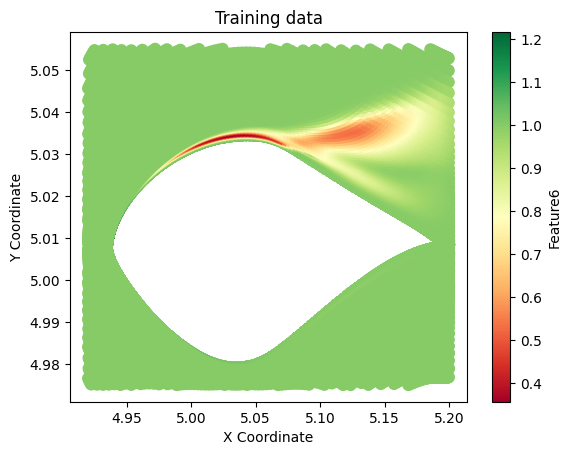

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dff = pd.read_csv("/content/drive/MyDrive/data_set3.csv")

# dff.loc[dff['beta']<0.995, "beta"] = 1.5
# dff.loc[dff['beta']>1.005, "beta"] = 1.5


frames = [dff]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  ff1 = np.array(item['feature1'])
  ff2 = np.array(item['feature2'])
  ff3 = np.array(item['feature3'])
  ff4 = np.array(item['feature4'])
  ff5 = np.array(item['feature5'])
  ff6 = np.array(item['feature6'])

  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  x1,y1,b1,f1,f2,f3,f4,f5,f6 = [[] for i in range(9)]
  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.92 and xc[i]<=5.20:
      if yc[i]>=4.975 and yc[i]<=5.055:
        # if (b[i]<0.995) | (b[i]>1.005):
          x1.append(xc[i])
          y1.append(yc[i])
          b1.append(b[i])
          f1.append(ff1[i])
          f2.append(ff2[i])
          f3.append(ff3[i])
          f4.append(ff4[i])
          f5.append(ff5[i])
          f6.append(ff6[i])

  modified_data = {
  'x': np.array(x1),
  'y': np.array(y1),
  'beta': np.array(b1),
  'feature1': np.array(f1),
  'feature2': np.array(f2),
  'feature3': np.array(f3),
  'feature4': np.array(f4),
  'feature5': np.array(f5),
  'feature6': np.array(f6)
  }


  ff.append(pd.DataFrame(modified_data))

  # Create a scatter plot
  plt.scatter(x1, y1, c=b1,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  plt.colorbar(label='Feature6')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('Training data')
  plt.show()
###############################################################################

dff1 = pd.concat(ff)

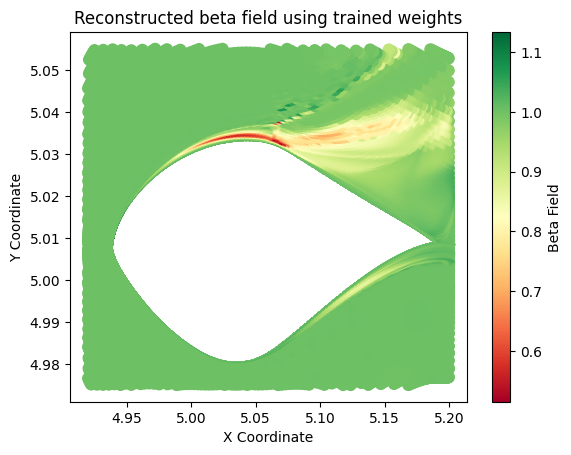

In [15]:
dff2 = dff1.drop(['x','y','beta'],axis=1)
X2 = dff2.values
X2 = torch.FloatTensor(X2)
y2 = model.forward(X2)
y2 = y2.detach().numpy()

# Create a scatter plot
plt.scatter(x1, y1, c=y2,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
plt.colorbar(label='Beta Field')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Reconstructed beta field using trained weights')
plt.show()


In [16]:
X3 = dff2.values
X3 = np.array(X3,dtype=np.float32)
y3 = tf_model_final.predict(X3)

1530/1530 [==============================] - 6s 4ms/step


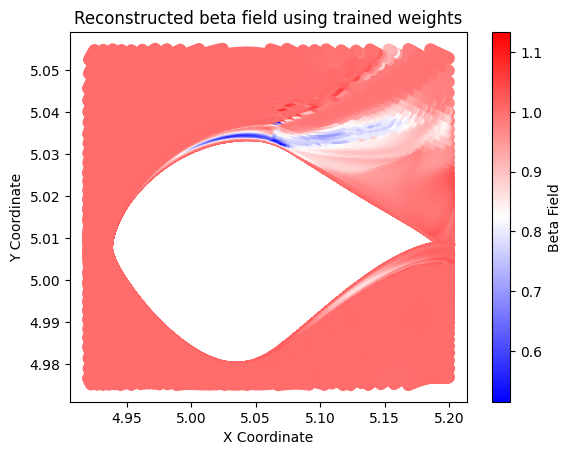

In [22]:
# Create a scatter plot
plt.scatter(x1, y1, c=y3,  cmap= 'bwr',alpha=1, marker='.',s=250)
plt.colorbar(label='Beta Field')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Reconstructed beta field using trained weights')
plt.show()

In [32]:
import numpy as np

def check_arrays_close(arr1, arr2, tolerance=1e-32):
    if np.allclose(arr1, arr2, atol=tolerance):
        print("The arrays are the same within the tolerance level.")
    else:
        print("The arrays are different within the tolerance level.")

def check_arrays_equal(arr1, arr2):
    if np.array_equal(arr1, arr2):
        print("The arrays are exactly the same.")
    else:
        print("The arrays are different.")

def find_differences(arr1, arr2):
    if arr1.shape != arr2.shape:
        print("The arrays have different shapes and cannot be compared element-wise.")
        return

    diff_indices = np.where(arr1 != arr2)
    if diff_indices[0].size == 0:
        print("The arrays are exactly the same.")
    else:
        print("The arrays are different at the following indices:")
        for index in zip(*diff_indices):
            print(f"Index {index}: arr1 = {arr1[index]}, arr2 = {arr2[index]}")

print("Check if arrays are close:")
check_arrays_close(y2, y3)
print("\nCheck if arrays are exactly equal:")
check_arrays_equal(y2, y3)
print("\nFind differences:")
find_differences(y2, y3)


Streaming output truncated to the last 5000 lines.
Index (33408, 0): arr1 = 1.0029183626174927, arr2 = 1.0029181241989136
Index (33409, 0): arr1 = 1.004267930984497, arr2 = 1.0042680501937866
Index (33410, 0): arr1 = 1.0016181468963623, arr2 = 1.0016182661056519
Index (33415, 0): arr1 = 1.0018950700759888, arr2 = 1.0018951892852783
Index (33416, 0): arr1 = 1.0017931461334229, arr2 = 1.0017932653427124
Index (33417, 0): arr1 = 1.0017831325531006, arr2 = 1.001783013343811
Index (33423, 0): arr1 = 1.001784086227417, arr2 = 1.0017839670181274
Index (33424, 0): arr1 = 1.001783847808838, arr2 = 1.0017839670181274
Index (33430, 0): arr1 = 1.0018812417984009, arr2 = 1.0018811225891113
Index (33431, 0): arr1 = 1.0019114017486572, arr2 = 1.0019116401672363
Index (33434, 0): arr1 = 1.0018525123596191, arr2 = 1.0018523931503296
Index (33435, 0): arr1 = 1.001796841621399, arr2 = 1.0017967224121094
Index (33438, 0): arr1 = 1.001464605331421, arr2 = 1.0014647245407104
Index (33439, 0): arr1 = 1.00177